In [17]:
import sys
import random
import numpy
import copy
import matplotlib.pyplot as plt
import re
%matplotlib inline 

In [68]:
file = open('lessnoisydata.gdat')
lst = []
for line in file:
    lst += [line.split()]
time = [x[0] for x in lst]
el = [float(x[1]) for x in lst[1:]]

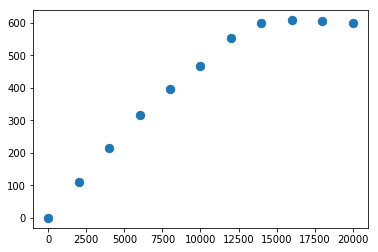

In [69]:
#plotting our experimental data
plt.figure
plt.scatter(time[1:],el,s=70)

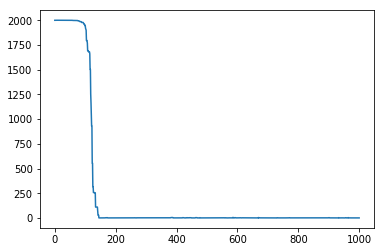

In [53]:
#Plot energy_chain
energy_chain_file = open('../parameter_estimation_results/mcmc/step_size0.2/energy_chain.txt')
lst = []
for line in energy_chain_file:
    lst += [line.split()]
energy_chain = [float(x[0]) for x in lst];
plt.plot(energy_chain);

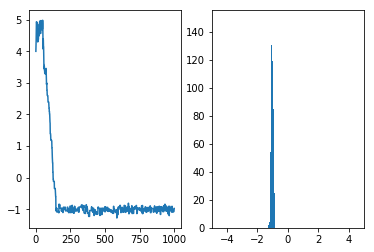

In [21]:
#Plot parameter_chain
parameter_chain_file = open('../parameter_estimation_results/mcmc/step_size0.2/parameter_chain.txt')
lst = []
for line in parameter_chain_file:
    lst += [line.split()]
parameter_chain = [float(x[0]) for x in lst];
#print(parameter_chain);
plt.subplot(1,2,1);
plt.plot(parameter_chain);
ax2 = plt.subplot(1,2,2);
plt.hist(numpy.array(parameter_chain[400:]));
ax2.set_xlim(-5,5);

In [49]:
#Read simulation results, both accepted and proposed
relpath = '../parameter_estimation_results/mcmc/step_size0.2/'
npts = len(energy_chain);

proposal_base_filename = 'proposal_step_'
proposal_results = [[] for i in range(0,npts-1)]
for i in range(1,npts):
    file = open(relpath+proposal_base_filename+str(i)+'.gdat')
    for line in file:
        proposal_results[i-1] += [line.split()]

base_filename = 'step_'
results = [[] for i in range(0,npts)]
for i in range(0,npts):
    file = open(relpath+base_filename+str(i)+'.gdat')
    for line in file:
        results[i] += [line.split()]

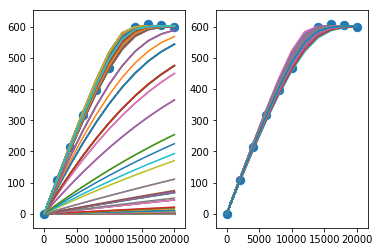

In [141]:
#Plot the burn in and fitted ensemble
plt.subplot(1,2,1)
burnin_results = [[] for i in range(0,400)];
counter = 0;
for i in range(0,400):
    tmp = [x[1] for x in results[i]];
    burnin_results[counter] = tmp[1:];
    counter = counter+1;
    plt.plot(time[1:],burnin_results[counter-1]);
    plt.hold
plt.scatter(time[1:],el,s=70)

plt.subplot(1,2,2)
sim_results = [[] for i in range(400,npts)];
counter = 0;
for i in range(400,npts):
    tmp = [x[1] for x in results[i]];
    sim_results[counter] = tmp[1:];
    counter = counter+1;
    plt.plot(time[1:],sim_results[counter-1]);
    plt.hold
plt.scatter(time[1:],el,s=70)

In [23]:
# display some timing results
output_file = open('../test_run_eof.out');

for line in output_file:
    lst = line.split();
    for j in lst:
        if j == 'multiparameter_estimation':
            t = (lst[3]);
            
print("took "+str(t)+" seconds to run " + str(len(energy_chain)-1)+" mcmc steps")

took 9.12 seconds to run 1000 mcmc steps


In [127]:
# Check that the energy values are correct

sd = 0.05;
for i in range(0,npts):
    tmp = [x[1] for x in results[i]]
    tmp = [float(x) for x in tmp[1:]]
    sim_results = numpy.array(tmp);
    energy = energy_chain[i];
    exp_results = numpy.array(el);
    
    energy_should_be = sum(numpy.divide((numpy.square(numpy.subtract(sim_results,exp_results))),2*numpy.square(sd*(exp_results+1e-20))));
    energy_is = energy_chain[i];
    if round(energy_is,6) != round(energy_should_be,6):
        print("problem with energy chain at step "+str(i));
        print(energy_is);
        print(energy_should_be)
        break
        

In [140]:
sd = 0.05;
for i in range(0,npts-1):
    tmp = [x[1] for x in proposal_results[i]]
    tmp = [float(x) for x in tmp[1:]]
    sim_results = numpy.array(tmp);
    energy = proposed_energy_chain[i];
    exp_results = numpy.array(el);
    
    energy_should_be = sum(numpy.divide((numpy.square(numpy.subtract(sim_results,exp_results))),2*numpy.square(sd*(exp_results+1e-20))));
    energy_is = proposed_energy_chain[i];
    if round(energy_is,6) != round(energy_should_be,6):
        p = proposed_parameter_chain[i];
        if p <=5 and p >= -5:
            print("problem with energy chain at step "+str(i));
            print(energy_is);
            print(energy_should_be)
            break

In [55]:
# Read the rest of the files
acceptance_chain_file = open('../parameter_estimation_results/mcmc/step_size0.2/accept_random_stream.txt')
lst = []
for line in acceptance_chain_file:
    lst += [line.split()]
acceptance_chain = [float(x[0]) for x in lst];

walk_chain_file = open('../parameter_estimation_results/mcmc/step_size0.2/walk_random_stream.txt')
lst = []
for line in walk_chain_file:
    lst += [line.split()]
walk_chain = [float(x[0]) for x in lst];

proposed_parameter_chain_file = open('../parameter_estimation_results/mcmc/step_size0.2/proposed_parameter_chain.txt')
lst = []
for line in proposed_parameter_chain_file:
    lst += [line.split()]
proposed_parameter_chain = [float(x[0]) for x in lst];

proposed_energy_chain_file = open('../parameter_estimation_results/mcmc/step_size0.2/proposed_energy_chain.txt')
lst = []
for line in proposed_energy_chain_file:
    lst += [line.split()]
proposed_energy_chain = [float(x[0]) for x in lst];

In [61]:
# Retrace the MCMC steps to make sure everything is working correctly

current_parameter = parameter_chain[0];
current_energy = energy_chain[0];
nsteps = len(acceptance_chain);
ss = 0.2;

for i in range(0,nsteps):
    proposed_value_should_be = current_parameter+ss*walk_chain[i];
    proposed_value_is = proposed_parameter_chain[i];
    
    #check equality up to 10 decimal places. I think python and perl have different precisions, so the equality doesn't hold unless you round
    if round(proposed_value_should_be,10) != round(proposed_value_is,10):
        print("we have a problem with the proposed value at step "+str(i))
        print(proposed_value_should_be)
        print(proposed_value_is)
        break
        
    proposed_energy_is = proposed_energy_chain[i];
    
    energy_diff = proposed_energy_is - current_energy;
   
    h = min(0,-energy_diff);
    acceptance_decision_should_be = acceptance_chain[i] < numpy.exp(h); # 1 if the random number is less, 0 if it is more
    
    acceptance_decision_is = parameter_chain[i+1] == proposed_value_is;
    
    if acceptance_decision_should_be != acceptance_decision_is:
        print("we have a problem with the acceptance decision at step "+str(i))
        break
    
    if acceptance_decision_is == 1:
        current_energy = proposed_energy_is;
        current_parameter =  proposed_value_is;    
        
if i == nsteps-1:
    print("no problems")

no problems
